# CSE 252A Computer Vision I Fall 2021 - Assignment 1

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [15]:
def normalize(img):
    maxi = img.max()
    mini = img.min()
    return (img - mini)/(maxi-mini)

def get_grayscale(rgb_image):
    img = 0.2989 * rgb_image[:,:,0] + 0.5870 * rgb_image[:,:,1] + 0.1140 * rgb_image[:,:,2]
    return img

## Photometric Stereo, Specularity Removal (20 pts)

The goal of this problem is to implement a couple of different algorithms that reconstruct a surface using the concept of Lambertian photometric stereo. Additionally, we implement the specular removal technique of [Mallick et al.](http://www.eecs.harvard.edu/~zickler/download/photodiff_cvpr05_preprint.pdf), which enables photometric stereo to be performed on certain non-Lambertian materials.

You can assume a Lambertian reflectance function once specularities are removed. However, note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image. Each image is associated with only a single light, and hence a single direction.

### Data
You will use synthetic images and specular sphere images as data. These images are stored in `.pickle` files which have been graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.

### Lambertian Photometric Stereo [8 pts]

Process
1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. We first try the naive scanline-based "shape by integration" method described. For comparison, we use the Horn technique which is implemented in the `horn_integrate` function.

You will find all the data for this part in `synthetic_data.pickle`.

Then use all four images (most accurate).

In [1]:
import numpy as np
from scipy.signal import convolve

def horn_integrate(gx, gy, mask, niter=1000):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [2]:
def photometric_stereo(images, lights, mask, horn_niter=2500):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale, averaging them,
    normalizing to [0, 1] and thresholding (only using locations for which the
    pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 or 0.1 tends to work well.
    
    You do not need to use the mask for 1a (it shouldn't matter),
    but you SHOULD use it to filter out the background for the specular data (1c).
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    # Storing intensities for image source in a hxwxn array 
    E = np.dstack(images)
    
    # Pseudo inverse of the direction of lights 
    source_inverse = np.matmul(np.linalg.inv(np.matmul(lights.T, lights)), lights.T)


    # Non normalised albedo -> b = a*normals
    # initialise b, albedo and normals 
    b = np.zeros((images[0].shape[0], images[0].shape[1], 3))
    albedo = np.zeros((images[0].shape[0], images[0].shape[1]))
    normals = np.zeros((images[0].shape[0], images[0].shape[1], 3))
    
    # b = S+.E for every pixel
    for i in range(images[0].shape[0]):
        for j in range(images[0].shape[1]):
            b[i][j]=source_inverse.dot(E[i][j])
            albedo[i][j]=np.linalg.norm(b[i][j])
            normals[i][j]=b[i][j]/albedo[i][j]
            
    H = np.zeros(images[0].shape)
    gx= normals[:,:,0]/normals[:,:,2]
    gy= normals[:,:,1]/normals[:,:,2]
    
    # image is following left hand coordinate system
    for j in range(1, normals.shape[1]):
        if mask[0][j]==1:
            H[0][j]=H[0][j-1]+gx[0][j]*(-1)*(-1) # (-1) as direction left to right. 2. *(-1) as we want depth and not height
    
    for j in range(normals.shape[1]):
        # Along a col is y axis
        for i in range(1,normals.shape[0]):
            if mask[i][j]==1:
                H[i][j]=H[i-1][j]+gy[i][j]*(-1)*(-1) # (-1) as direction top to bottom. 2. *(-1) as we want depth and not height

    
    H_horn = horn_integrate(gx, gy, mask, horn_niter)
    
    return albedo, normals, H, H_horn

In [3]:
def visualize(albedo, normals, depth, horn, stride = 15):
    # Stride in the plot, you may want to adjust it to different images
    

    # showing albedo map
    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(top=1)
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    ax0 = fig.add_subplot(332)
    ax0.imshow(albedo, cmap="gray")
    ax0.title.set_text("Albedo")

    # showing normals as three separate channels
    ax1 = fig.add_subplot(334)
    ax1.imshow(normals[..., 0])
    ax1.title.set_text("Nx")
    ax2 = fig.add_subplot(335)
    ax2.imshow(normals[..., 1])
    ax2.title.set_text("Ny")
    ax3 = fig.add_subplot(336)
    ax3.imshow(normals[..., 2])
    ax3.title.set_text("Nz")


    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                          np.arange(0,np.shape(normals)[1], stride),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    ax4 = fig.add_subplot(337, projection='3d')
    ax4.quiver(X,Y,Z,NX,NY,NZ, length=10)
    ax4.title.set_text("Needle Map")
    # plotting wireframe depth map
    H = depth[::stride,::stride]
    ax5 = fig.add_subplot(338, projection='3d')
    ax5.plot_surface(X,Y, H.T)
    ax5.title.set_text("Depth Map")

    H = horn[::stride,::stride]
    ax6 = fig.add_subplot(339, projection='3d')
    ax6.plot_surface(X,Y, H.T)
    ax6.title.set_text("Depth Map by Horn's method")

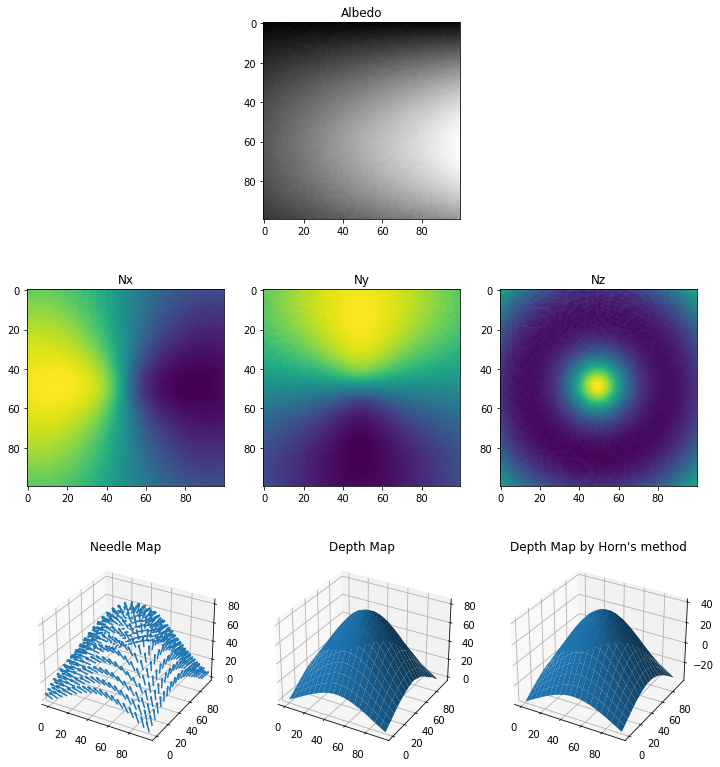

In [9]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

visualize(albedo, normals, depth, horn, stride=5)

### Specularity Removal [6 pts]

Implementing the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).

In [10]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) # axis of rotation

    rcos = np.dot(rot_v, unit) # cos by dot product
    rsin = np.linalg.norm(uvw) # sin by magnitude of cross product

    # normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    return R

## This function implementation assumes that the I_rgb image is normalised
# One can add a line I_rgb = normalize(I_rgb) 
def RGBToSUV(I_rgb, rot_vec):
    '''
    Your implementation which takes an RGB image and a vector encoding
    the orientation of the S channel w.r.t. to RGB.
    '''

    """ ==========
    YOUR CODE HERE
    ========== """

    # Initialise I_suv
    I_suv = np.zeros_like(I_rgb)
    
    # normalize input image
    # I_rgb = I_rgb
    # Get the rotation matrix
    R = get_rot_mat(rot_vec)
    
    # Rotate the original image so that the S channel is aligned with the first axis given by R
    #(which represents the colour of light)
    for i in range(I_rgb.shape[0]):
        for j in range(I_rgb.shape[1]):
            I_suv[i][j]=R.dot(I_rgb[i][j])
        
    # Spectral Channel
    S = I_suv[:,:,0]
    # Diffuse Channel
    G = (I_suv[:,:,1]**2+I_suv[:,:,2]**2)**0.5
    return S, G

### Comparison for Sphere

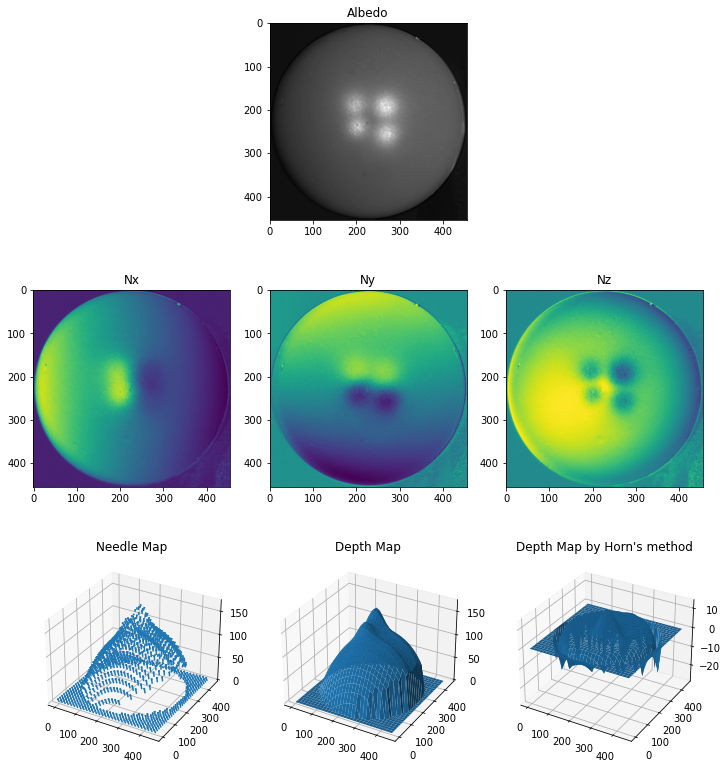

In [16]:
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(get_grayscale(normalize(data["im1"])))
images.append(get_grayscale(normalize(data["im2"])))
images.append(get_grayscale(normalize(data["im3"])))
images.append(get_grayscale(normalize(data["im4"])))
images = np.array(images)

th = 0.12
mask = np.zeros_like(images[0])
for i in images:
    mask+=i
mask=mask/4
mask[mask<th]=0
mask[mask>=th]=1


albedo, normals, depth, horn = photometric_stereo(images, lights, mask, horn_niter=1000)

visualize(albedo, normals, depth, horn, stride=15)

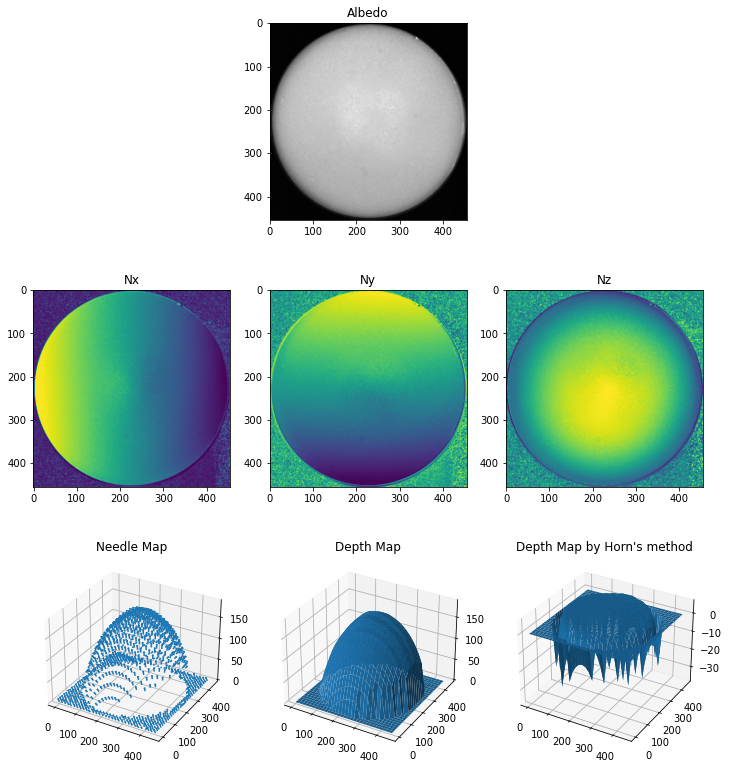

In [17]:
### Removing Specular channel and running comparison on Diffuse channels

color_ = np.hstack((data["c"][0][0], data["c"][1][0], data["c"][2][0])) 

S1, G1 = RGBToSUV(normalize(data["im1"]), color_ )
S2, G2 = RGBToSUV(normalize(data["im2"]), color_ )
S3, G3 = RGBToSUV(normalize(data["im3"]), color_ )
S4, G4 = RGBToSUV(normalize(data["im4"]), color_ )
images = []
images.append(G1)
images.append(G2)
images.append(G3)
images.append(G4)
images = np.array(images)

th = 0.12
mask = np.zeros_like(images[0])
for i in images:
    mask+=i
mask=mask/4
mask[mask<th]=0
mask[mask>=th]=1

albedo_d, normals_d, depth_d, horn_d = photometric_stereo(images, lights, mask, horn_niter=1000)
visualize(albedo_d, normals_d, depth_d, horn_d, stride=15)